# Crime Analytics in Seattle and San Francisco

In [2]:
YEAR = 2014
PERIOD = "summer"
TYPE = "incidents"
DATA_DIR = "data"
SF = "sanfrancisco"
SEATTLE = "seattle"

In [16]:
# Load data into pandas DataFrames
import os
import pandas as pd

sf_filename = os.path.join(DATA_DIR, "%s_%s_%s_%d.csv" % (SF, TYPE, PERIOD, YEAR))
sf = pd.read_csv(sf_filename)
sf_nrows = sf.shape[0]
print "Read SF data from %s yielded %d rows" % (sf_filename, sf_nrows)

seattle_filename = os.path.join(DATA_DIR, "%s_%s_%s_%d.csv" % (SEATTLE, TYPE, PERIOD, YEAR))
seattle = pd.read_csv(seattle_filename)
seattle_nrows = seattle.shape[0]
print "Read Seattle data from %s yielded %d rows" % (seattle_filename, seattle_nrows)

assert sf_nrows == len(open(sf_filename).readlines()) - 1 != 0
assert seattle_nrows == len(open(seattle_filename).readlines()) - 1 != 0

Read SF data from data/sanfrancisco_incidents_summer_2014.csv yielded 28993 rows
Read Seattle data from data/seattle_incidents_summer_2014.csv yielded 32779 rows


In [4]:
sf.head(5)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,140734311,ARSON,ARSON OF A VEHICLE,Sunday,08/31/2014,23:50,BAYVIEW,NONE,LOOMIS ST / INDUSTRIAL ST,-122.405647,37.738322,"(37.7383221869053, -122.405646994567)",14073431126031
1,140736317,NON-CRIMINAL,LOST PROPERTY,Sunday,08/31/2014,23:45,MISSION,NONE,400 Block of CASTRO ST,-122.435012,37.761768,"(37.7617677182954, -122.435012093789)",14073631771000
2,146177923,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,08/31/2014,23:30,SOUTHERN,NONE,1000 Block of MISSION ST,-122.409795,37.780036,"(37.7800356268394, -122.409795194505)",14617792306244
3,146177531,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,08/31/2014,23:30,RICHMOND,NONE,FULTON ST / 26TH AV,-122.485263,37.772518,"(37.7725176473142, -122.485262988324)",14617753106244
4,140734220,NON-CRIMINAL,FOUND PROPERTY,Sunday,08/31/2014,23:23,RICHMOND,NONE,800 Block of LA PLAYA ST,-122.509895,37.772313,"(37.7723131976814, -122.509895418239)",14073422072000


In [5]:
seattle.head(5)

,RMS CDW ID,General Offense Number,Offense Code,Offense Code Extension,Offense Type,Summary Offense Code,Summarized Offense Description,Date Reported,Occurred Date or Date Range Start,Occurred Date Range End,Hundred Block Location,District/Sector,Zone/Beat,Census Tract 2000,Longitude,Latitude,Location,Month,Year
0,483839,2015218538,2202,0,BURGLARY-FORCE-RES,2200,BURGLARY,06/28/2015 10:31:00 AM,06/28/2014 10:31:00 AM,06/28/2015 10:31:00 AM,6XX BLOCK OF NW 74 ST,J,J2,2900.3013,-122.364672,47.682524,"(47.68252427, -122.364671996)",6,2014
1,481252,2015213067,2610,0,FRAUD-IDENTITY THEFT,2600,FRAUD,06/24/2015 11:09:00 AM,06/01/2014 12:00:00 AM,06/24/2015 11:09:00 AM,23XX BLOCK OF 43 AV E,C,C2,6300.1004,-122.277080,47.639901,"(47.639900761, -122.277080248)",6,2014
2,481375,2015210301,2316,0,THEFT-MAIL,2300,MAIL THEFT,06/22/2015 09:22:00 AM,08/31/2014 09:00:00 AM,NaN,81XX BLOCK OF 11 AV SW,F,F3,11300.5013,-122.349312,47.529232,"(47.529232299, -122.349312181)",8,2014
3,481690,2015209327,2599,0,COUNTERFEIT,2500,COUNTERFEIT,06/21/2015 03:52:00 PM,06/20/2014 01:38:00 PM,NaN,6XX BLOCK OF PINE ST,M,M2,8200.1002,-122.334818,47.612368,"(47.612368448, -122.334817763)",6,2014
4,478198,2015207880,2399,3,THEFT-OTH,2300,OTHER PROPERTY,06/20/2015 11:59:00 AM,06/01/2014 11:59:00 AM,11/01/2014 12:00:00 PM,77XX BLOCK OF SUNNYSIDE AV N,J,J3,2700.2015,-122.329379,47.685960,"(47.685959879, -122.329378505)",6,2014


## Data Preprocessing and Normalization

In [6]:
import shapefile 

ZILLOW_PREFIX = "ZillowNeighborhoods"
CA_NEIGHBORHOODS = os.path.join(DATA_DIR, "%s-CA.shp" % ZILLOW_PREFIX)
WA_NEIGHBORHOODS = os.path.join(DATA_DIR, "%s-WA.shp" % ZILLOW_PREFIX)

def point_in_poly(x,y,poly):
    #check if point is a vertex
    if (x,y) in poly: return True

    # check if point is on a boundary
    for i in range(len(poly)):
        p1 = None
        p2 = None
        if i==0:
            p1 = poly[0]
            p2 = poly[1]
        else:
            p1 = poly[i-1]
            p2 = poly[i]
        if p1[1] == p2[1] and p1[1] == y and x > min(p1[0], p2[0]) and x < max(p1[0], p2[0]):
            return True

    n = len(poly)
    inside = False

    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if y > min(p1y,p2y):
            if y <= max(p1y,p2y):
                if x <= max(p1x,p2x):
                    if p1y != p2y:
                        xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x,p1y = p2x,p2y

    return inside

ca_shp = shapefile.Reader(CA_NEIGHBORHOODS)
wa_shp = shapefile.Reader(WA_NEIGHBORHOODS)

ca_sr = ca_shp.shapeRecords()
wa_sr = wa_shp.shapeRecords()

sf_sr = [x for x in ca_sr if x.record[2] == "San Francisco"]
seattle_sr = [x for x in wa_sr if x.record[2] == "Seattle"]

UNKNOWN = "Unknown"
def sf_neighborhood(row):
    for sr in sf_sr:
        if point_in_poly(row["Longitude"], row["Latitude"], sr.shape.points):
            return sr.record[3]
    return UNKNOWN

def seattle_neighborhood(row):
    for sr in seattle_sr:
        if point_in_poly(row["Longitude"], row["Latitude"], sr.shape.points):
            return sr.record[3]
    return UNKNOWN

In [92]:
sf.rename(columns = {"X": "Longitude", "Y": "Latitude", "PdDistrict": "District", "Descript": "Description"}, 
          inplace=True)
sf["City"] = pd.Series([SF]*sf.shape[0], index=sf.index)
sf["DayOfMonth"] = sf.Date.map(lambda x: int(x.split("/")[1]))
sf["Month"] = sf.Date.map(lambda x: int(x.split("/")[0]))
sf["Year"] = sf.Date.map(lambda x: int(x.split("/")[2]))
sf["Neighborhood"] = sf.apply(sf_neighborhood, axis=1)

def time_bin(t, bin_size=30):
    hour, mins = t.split(":")
    return int(hour)
    #total_mins = int(hour)*60 + int(mins)
    #bin_mins = total_mins - (total_mins % bin_size)
    #return "{0:0>2}:{1:0>2}".format(bin_mins/60, bin_mins%60)
    
sf["TimeBin"] = sf.Time.map(time_bin)
sf.drop(["IncidntNum", "PdId", "Location", "Resolution"], axis=1, inplace=True, errors="ignore")
# Reindex the DataFrame
sf_columns_index = ["City", "DayOfMonth", "DayOfWeek", "Month", "Year", "Time", "TimeBin",
                    "Longitude", "Latitude", "Address", "District", "Neighborhood", 
                    "Category", "Description"
                   ]
sf_normalized = sf[sf_columns_index]
sf_normalized.sample(n=5)

,City,DayOfMonth,DayOfWeek,Month,Year,Time,TimeBin,Longitude,Latitude,Address,District,Neighborhood,Category,Description
4931,sanfrancisco,16,Saturday,8,2014,19:10,19,-122.414056,37.782793,LEAVENWORTH ST / TURK ST,TENDERLOIN,Downtown,WARRANTS,WARRANT ARREST
16400,sanfrancisco,12,Saturday,7,2014,15:12,15,-122.412483,37.770631,11TH ST / HARRISON ST,SOUTHERN,South Of Market,ASSAULT,AGGRAVATED ASSAULT WITH A DEADLY WEAPON
27483,sanfrancisco,5,Thursday,6,2014,20:00,20,-122.450998,37.773782,100 Block of COLE ST,PARK,Haight-Ashbury,OTHER OFFENSES,HARASSING PHONE CALLS
12615,sanfrancisco,24,Thursday,7,2014,16:00,16,-122.423242,37.730820,TRUMBULL ST / NEY ST,INGLESIDE,Excelsior,VEHICLE THEFT,STOLEN AUTOMOBILE
15805,sanfrancisco,14,Monday,7,2014,12:30,12,-122.405448,37.791300,0 Block of QUINCY ST,CENTRAL,Chinatown,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO


In [93]:
import datetime

seattle_drop_columns = ["RMS CDW ID", 
                        "General Offense Number", 
                        "Offense Code", 
                        "Offense Code Extension", 
                        "Summary Offense Code",
                        "Census Tract 2000",
                        "Location"
                       ]
seattle.drop(seattle_drop_columns, axis=1, inplace=True, errors="ignore")
seattle.rename(columns = {"Hundred Block Location": "Address", "Offense Type": "Category", 
                          "Summarized Offense Description": "Description",
                          "District/Sector": "District"}, 
               inplace=True)
seattle["City"] = pd.Series([SEATTLE]*seattle.shape[0], index=seattle.index)
seattle["DayOfMonth"] = seattle["Occurred Date or Date Range Start"].map(lambda x: int(x.split(" ")[0].split("/")[1]))
seattle["DayOfWeek"] = seattle["Occurred Date or Date Range Start"] \
    .map(lambda x: datetime.datetime.strptime(x.split(" ")[0], "%m/%d/%Y").strftime("%A"))
seattle["Time"] = seattle["Occurred Date or Date Range Start"] \
    .map(lambda x: datetime.datetime.strptime(x[11:], "%I:%M:%S %p").strftime("%H:%M"))
seattle["Neighborhood"] = seattle.apply(seattle_neighborhood, axis=1)
seattle["TimeBin"] = seattle.Time.map(time_bin)
# Reindex the DataFrame
seattle_columns_index = ["City", "DayOfMonth", "DayOfWeek", "Month", "Year", "Time", "TimeBin",
                         "Longitude", "Latitude", "Address", "District", "Neighborhood", 
                         "Category", "Description"
                        ]
seattle_normalized = seattle[seattle_columns_index]
seattle_normalized.sample(n=5)

,City,DayOfMonth,DayOfWeek,Month,Year,Time,TimeBin,Longitude,Latitude,Address,District,Neighborhood,Category,Description
7974,seattle,10,Sunday,8,2014,22:40,22,-122.341081,47.620299,2XX BLOCK OF 8 AV N,D,South Lake Union,ASSLT-NONAGG,ASSAULT
11539,seattle,24,Thursday,7,2014,18:00,18,-122.320603,47.710397,110XX BLOCK OF 8 AV NE,L,Northgate,BURGLARY-NOFORCE-RES,BURGLARY
22541,seattle,30,Monday,6,2014,12:00,12,-122.362954,47.554483,52XX BLOCK OF DELRIDGE WY SW,F,North Delridge,BURGLARY-NOFORCE-RES,BURGLARY
7430,seattle,12,Tuesday,8,2014,15:23,15,-122.258073,47.550617,58XX BLOCK OF LAKE WASHINGTON BV S,R,Seward Park,THEFT-CARPROWL,CAR PROWL
21856,seattle,1,Tuesday,7,2014,19:20,19,-122.295248,47.721092,30XX BLOCK OF NE 127 ST,L,Olympic Hills,THEFT-BUILDING,OTHER PROPERTY


In [94]:
category_subset = {
    "RECKLESS BURNING": "ARSON",
    "THEFT-OTH": "LARCENY/THEFT",
    "BURGLARY-FORCE-NONRES": "BURGLARY",
    "INJURY - ACCIDENTAL": "OTHER OFFENSES",
    "ANIMAL-BITE": "ASSAULT",
    "ANIMAL-CRUELTY": "DISORDERLY CONDUCT",
    "ANIMAL-OTH": "OTHER OFFENSES",
    "ASSLT-AGG-BODYFORCE": "ASSAULT",
    "ASSLT-AGG-GUN": "ASSAULT",
    "ASSLT-AGG-POLICE-BODYFORCE": "ASSAULT",
    "ASSLT-AGG-POLICE-GUN": "ASSAULT",
    "ASSLT-AGG-POLICE-WEAPON": "ASSAULT",
    "ASSLT-AGG-WEAPON": "ASSAULT",
    "ASSLT-NONAGG": "ASSAULT",
    "ASSLT-NONAGG-POLICE": "ASSAULT",
    "BIAS INCIDENT": "NON-CRIMINAL",
    "BURGLARY-FORCE-RES": "BURGLARY",
    "BURGLARY-NOFORCE-NONRES": "BURGLARY",
    "BURGLARY-NOFORCE-RES": "BURGLARY",
    "BURGLARY-SECURE PARKING-NONRES": "BURGLARY",
    "BURGLARY-SECURE PARKING-RES": "BURGLARY",
    "COUNTERFEIT": "FORGERY/COUNTERFEITING",
    "DISPUTE-CIVIL PROPERTY (AUTO)": "NON-CRIMINAL",
    "DISPUTE-CIVIL PROPERTY (NON AU": "NON-CRIMINAL",
    "DISPUTE-OTH": "NON-CRIMINAL",
    "DISTURBANCE-NOISE": "NON-CRIMINAL",
    "DISTURBANCE-OTH": "NON-CRIMINAL",
    "DRIVE-BY": "ASSAULT",
    "DUI-DRUGS": "DRIVING UNDER THE INFLUENCE",
    "DUI-LIQUOR": "DRIVING UNDER THE INFLUENCE",
    "ELUDING-FELONY FLIGHT": "RUNAWAY",
    "EMBEZZLE": "EMBEZZLEMENT",
    "ENDANGERMENT": "OTHER OFFENSES",
    "ESCAPE": "RUNAWAY",
    "FALSE REPORT": "OTHER OFFENSES",
    "FIREWORK-POSSESS": "OTHER OFFENSES",
    "FIREWORK-USE": "OTHER OFFENSES",
    "FORGERY-CHECK": "FORGERY/COUNTERFEITING",
    "FORGERY-CREDIT CARD": "FORGERY/COUNTERFEITING",
    "FORGERY-OTH": "FORGERY/COUNTERFEITING",
    "FRAUD-CHECK": "FRAUD",
    "FRAUD-COMPUTER": "FRAUD",
    "FRAUD-CREDIT CARD": "FRAUD",
    "FRAUD-IDENTITY THEFT": "FRAUD",
    "FRAUD-OTHER": "FRAUD",
    "FRAUD-WIRE-ELECTRONIC": "FRAUD",
    "HARASSMENT": "DISORDERLY CONDUCT",
    "HOMICIDE-JUST-GUN": "ASSAULT",
    "HOMICIDE-JUST-WEAPON": "ASSAULT",
    "HOMICIDE-PREMEDITATED-GUN": "ASSAULT",
    "ILLEGAL DUMPING": "NON-CRIMINAL",
    "INJURY - OTHER": "OTHER OFFENSES",
    "LIQUOR LAW VIOLATION": "LIQUOR LAWS",
    "MALICIOUS HARASSMENT": "DISORDERLY CONDUCT",
    "NARC-DRUG TRAFFIC LOITERING": "DRUG/NARCOTIC",
    "NARC-EQUIPMENT/PARAPHENALIA": "DRUG/NARCOTIC",
    "NARC-FORGERY-PRESCRIPTION": "DRUG/NARCOTIC",
    "NARC-FOUND-AMPHETAMINE": "DRUG/NARCOTIC",
    "NARC-FOUND-COCAINE": "DRUG/NARCOTIC",
    "NARC-FOUND-HEROIN": "DRUG/NARCOTIC",
    "NARC-FOUND-MARIJU": "DRUG/NARCOTIC",
    "NARC-FOUND-METH": "DRUG/NARCOTIC",
    "NARC-FOUND-OPIUM": "DRUG/NARCOTIC",
    "NARC-FOUND-OTHER": "DRUG/NARCOTIC",
    "NARC-FOUND-SYNTHETIC": "DRUG/NARCOTIC",
    "NARC-FRAUD-PRESCRIPTION": "DRUG/NARCOTIC",
    "NARC-POSSESS-AMPHETAMINE": "DRUG/NARCOTIC",
    "NARC-POSSESS-COCAINE": "DRUG/NARCOTIC",
    "NARC-POSSESS-HALLUCINOGEN": "DRUG/NARCOTIC",
    "NARC-POSSESS-HEROIN": "DRUG/NARCOTIC",
    "NARC-POSSESS-MARIJU": "DRUG/NARCOTIC",
    "NARC-POSSESS-METH": "DRUG/NARCOTIC",
    "NARC-POSSESS-OTHER": "DRUG/NARCOTIC",
    "NARC-POSSESS-PILL/TABLET": "DRUG/NARCOTIC",
    "NARC-PRODUCE-MARIJU": "DRUG/NARCOTIC",
    "NARC-SELL-AMPHETAMINE": "DRUG/NARCOTIC",
    "NARC-SELL-COCAINE": "DRUG/NARCOTIC",
    "NARC-SELL-HEROIN": "DRUG/NARCOTIC",
    "NARC-SELL-MARIJU": "DRUG/NARCOTIC",
    "NARC-SELL-METH": "DRUG/NARCOTIC",
    "NARC-SELL-SYNTHETIC": "DRUG/NARCOTIC",
    "NARC-SMUGGLE-OTHER": "DRUG/NARCOTIC",
    "OBSTRUCT": "OTHER OFFENSES",
    "PORNOGRAPHY-OBSCENE MATERIAL": "PORNOGRAPHY/OBSCENE MAT",
    "PROP RECOVERED-OTHER AGENCY": "STOLEN PROPERTY",
    "PROPERTY DAMAGE - GRAFFITI": "VANDALISM",
    "PROPERTY DAMAGE-NON RESIDENTIA": "VANDALISM",
    "PROPERTY DAMAGE-RESIDENTIAL": "VANDALISM",
    "PROPERTY FOUND": "STOLEN PROPERTY",
    "PROPERTY LOST": "STOLEN PROPERTY",
    "PROPERTY LOST - POLICE EQUIPME": "STOLEN PROPERTY",
    "PROPERTY STOLEN-POSSESS": "STOLEN PROPERTY",
    "PROPERTY STOLEN-SELL": "STOLEN PROPERTY",
    "PROPERTY STOLEN-TRAFFICKING": "STOLEN PROPERTY",
    "PROSTITUTION LOITERING": "PROSTITUTION",
    "PROSTITUTION PATRONIZING": "PROSTITUTION",
    "PROSTITUTION-ASSIST-PROMOTE": "PROSTITUTION",
    "ROBBERY-BANK-BODYFORCE": "ROBBERY",
    "ROBBERY-BANK-GUN": "ROBBERY",
    "ROBBERY-BANK-WEAPON": "ROBBERY",
    "ROBBERY-BUSINESS-BODYFORCE": "ROBBERY",
    "ROBBERY-BUSINESS-GUN": "ROBBERY",
    "ROBBERY-BUSINESS-WEAPON": "ROBBERY",
    "ROBBERY-RESIDENCE-BODYFORCE": "ROBBERY",
    "ROBBERY-RESIDENCE-GUN": "ROBBERY",
    "ROBBERY-RESIDENCE-WEAPON": "ROBBERY",
    "ROBBERY-STREET-BODYFORCE": "ROBBERY",
    "ROBBERY-STREET-GUN": "ROBBERY",
    "ROBBERY-STREET-WEAPON": "ROBBERY",
    "THEFT OF SERVICES": "LARCENY/THEFT",
    "THEFT-AUTO PARTS": "LARCENY/THEFT",
    "THEFT-AUTOACC": "LARCENY/THEFT",
    "THEFT-BICYCLE": "LARCENY/THEFT",
    "THEFT-BOAT": "LARCENY/THEFT",
    "THEFT-BUILDING": "LARCENY/THEFT",
    "THEFT-CARPROWL": "LARCENY/THEFT",
    "THEFT-COINOP": "LARCENY/THEFT",
    "THEFT-LICENSE PLATE": "LARCENY/THEFT",
    "THEFT-MAIL": "LARCENY/THEFT",
    "THEFT-PKPOCKET": "LARCENY/THEFT",
    "THEFT-PRSNATCH": "LARCENY/THEFT",
    "THEFT-SHOPLIFT": "LARCENY/THEFT",
    "THREATS-KILL": "ASSAULT",
    "THREATS-OTHER": "OTHER OFFENSES",
    "THREATS-WEAPON": "ASSAULT",
    "TRAFFIC": "OTHER OFFENSES",
    "URINATING/DEFECATING-IN PUBLIC": "DISORDERLY CONDUCT",
    "VEH-RCVD-FOR OTHER AGENCY": "VEHICLE THEFT",
    "VEH-THEFT-AUTO": "VEHICLE THEFT",
    "VEH-THEFT-MTRCYCLE": "VEHICLE THEFT",
    "VEH-THEFT-OTHVEH": "VEHICLE THEFT",
    "VEH-THEFT-TRAILER": "VEHICLE THEFT",
    "VEH-THEFT-TRUCK": "VEHICLE THEFT",
    "VIOL-COURT ORDER": "OTHER OFFENSES",
    "WARRANT-FUGITIVE": "WARRANTS",
    "WARRARR-FELONY": "WARRANTS",
    "WARRARR-MISDEMEANOR": "WARRANTS",
    "WEAPON-CONCEALED": "WEAPON LAWS",
    "WEAPON-DISCHARGE": "WEAPON LAWS",
    "WEAPON-POSSESSION": "WEAPON LAWS",
    "WEAPON-SELLING": "WEAPON LAWS",
    "WEAPON-SURRENDER-EXCLUDING FIR": "WEAPON LAWS",
    "WEAPON-UNLAWFUL USE": "WEAPON LAWS",
    "[INC - CASE DC USE ONLY]": "OTHER OFFENSES"
}
for category, subset in category_subset.iteritems():
    seattle_normalized.loc[seattle_normalized["Category"] == category, "Category"] = subset

sf_categories = set(sf_normalized["Category"].tolist())
seattle_categories = set(seattle_normalized["Category"].tolist())
print "SF crime categories: %s" % ",".join(sorted(sf_categories))
print "Seattle crime categories: %s" % ",".join(sorted(seattle_categories))
assert seattle_categories <= sf_categories

SF crime categories: ARSON,ASSAULT,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,ROBBERY,RUNAWAY,SECONDARY CODES,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
Seattle crime categories: ARSON,ASSAULT,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,EMBEZZLEMENT,FORGERY/COUNTERFEITING,FRAUD,LARCENY/THEFT,LIQUOR LAWS,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,ROBBERY,RUNAWAY,STOLEN PROPERTY,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS


In [95]:
dataset = pd.concat([sf_normalized, seattle_normalized])
total_nrows = dataset.shape[0]
print "Total number of rows after union: %d" % total_nrows
assert total_nrows == sf_nrows + seattle_nrows

dataset.sample(n=5)

Total number of rows after union: 61772


,City,DayOfMonth,DayOfWeek,Month,Year,Time,TimeBin,Longitude,Latitude,Address,District,Neighborhood,Category,Description
17126,sanfrancisco,10,Thursday,7,2014,00:30,0,-122.407244,37.786565,100 Block of OFARRELL ST,TENDERLOIN,Downtown,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO
2715,seattle,26,Tuesday,8,2014,16:35,16,-122.324615,47.708603,4XX BLOCK OF NE NORTHGATE WY,L,Northgate,LARCENY/THEFT,SHOPLIFTING
11238,seattle,1,Friday,8,2014,10:24,10,-122.289922,47.568881,38XX BLOCK OF RAINIER AV S,R,Mount Baker,OTHER OFFENSES,THREATS
10279,seattle,2,Saturday,8,2014,08:00,8,-122.400936,47.645913,28XX BLOCK OF 34 AV W,Q,Magnolia,VANDALISM,PROPERTY DAMAGE
32588,seattle,1,Sunday,6,2014,19:45,19,-122.277123,47.636386,E MADISON ST / 43 AV E,C,Madison Park,LARCENY/THEFT,OTHER PROPERTY


## Data Analysis

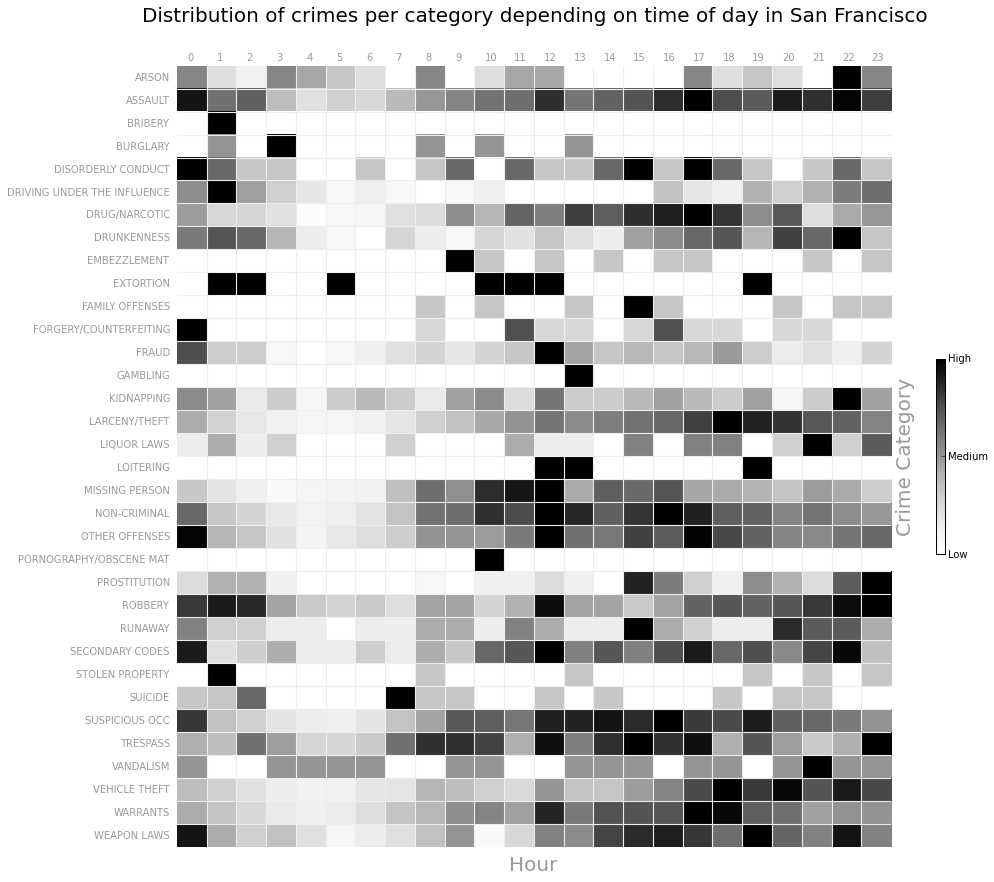

In [177]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as cbar

import numpy as np

categories = sorted(list(set(dataset.Category.tolist())))
n_categories = len(categories)
# matrix where the x-axis is the hour, and y-axis is the category
img_src = np.zeros((n_categories, 24))

# select data from SF and group by TimeBin (hour) and crime Category
gb = dataset[dataset["City"] == SF].groupby(["TimeBin", "Category"])

# add the frequencies of crime per hour in the matrix
for group, values in gb:
    timebin = group[0]
    category = group[1]
    value = values.shape[0]
    img_src[categories.index(category)][timebin] = value

# normalizing frequencies between 0 and 1 based on the max of each row
for row in img_src:
    m = max(row)
    for idx in range(len(row)):
        row[idx] = row[idx] / m

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

fig, ax = preparePlot(np.arange(.5, 23, 1), np.arange(.5, n_categories-1, 1), figsize=(16,14), hideLabels=True,
                      gridColor='#eeeeee', gridWidth=1.1)
image = plt.imshow(img_src, interpolation='nearest', aspect='auto', cmap=cm.Greys)
for x, y, s in zip(np.arange(-.125, 24, 1), np.repeat(-.75, 24), [str(x) for x in range(24)]):
    plt.text(x, y, s, color='#999999', size='10')
for x, y, s in zip(np.repeat(-.75, n_categories), np.arange(.125, n_categories, 1), categories):
    plt.text(x, y, s, color='#999999', size='10', horizontalalignment="right")
plt.title("Distribution of crimes per category depending on time of day in San Francisco", size=20, y=1.05)
plt.xlabel("Hour", color='#999999', size="20")
plt.ylabel("Crime Category", color='#999999', size="20")
ax.yaxis.set_label_position("right")

# plot the colobar to show scale
cbar = fig.colorbar(image, ticks=[0, 0.5, 1], shrink=0.25, orientation='vertical')
cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])

plt.show()